Based on the notes from http://cs231n.github.io/

#1 Image Classification: Data-driven Approach, k-Nearest Neighbor, train/val/test splits

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread, imsave, imresize
%matplotlib inline

In [2]:
def load_CIFAR10(cifar10dir):
    import pickle
    files = ['data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
    with open(cifar10dir + 'data_batch_1', 'rb') as fo:
        db = pickle.load(fo, encoding='bytes')
        Xtr = db[b'data']
        Ytr = np.array(db[b'labels'], dtype=np.uint8)
    for file in files:
        with open(cifar10dir + file, 'rb') as fo:
            db = pickle.load(fo, encoding='bytes')
            Xtr = np.concatenate( ( Xtr, db[b'data'] ) )
            Ytr = np.concatenate( ( Ytr, np.array(db[b'labels'], dtype=np.uint8) ) )
    with open(cifar10dir + 'test_batch', 'rb') as fo:
        db = pickle.load(fo, encoding='bytes')
        Xte = db[b'data']
        Yte = np.array(db[b'labels'], dtype=np.uint8)
    
    Xtr = np.reshape(Xtr, (Xtr.shape[0],32, 32, 3), 'F')
    Xtr = np.swapaxes(Xtr, 1, 2)
    
    Xte = np.reshape(Xte, (Xte.shape[0],32, 32, 3), 'F')
    Xte = np.swapaxes(Xte, 1, 2)
    
    with open(cifar10dir + 'batches.meta', 'rb') as fo:
        meta = pickle.load(fo, encoding='bytes')
        labelNames = meta[b'label_names']
        for i in range(len(labelNames)):
            labelNames[i] = labelNames[i].decode("utf-8")
    
    
    return Xtr, Ytr, Xte, Yte, labelNames

In [3]:
Xtr, Ytr, Xte, Yte, labelNames = load_CIFAR10('cifar-10-batches-py/')

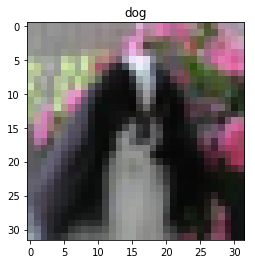

In [4]:
idx=42
plt.title(labelNames[Yte[idx]])
plt.imshow(Xte[idx])
plt.show()

In [5]:
Xtr_rows = Xtr.reshape(Xtr.shape[0], 32 * 32 * 3) # Xtr_rows becomes 50000 x 3072
Xte_rows = Xte.reshape(Xte.shape[0], 32 * 32 * 3) # Xte_rows becomes 10000 x 3072

In [6]:
class NearestNeighbor(object):
  def __init__(self):
    pass

  def train(self, X, y):
    """ X is N x D where each row is an example. Y is 1-dimension of size N """
    # the nearest neighbor classifier simply remembers all the training data
    self.Xtr = X
    self.ytr = y

  def predict(self, X):
    """ X is N x D where each row is an example we wish to predict label for """
    num_test = X.shape[0]
    # lets make sure that the output type matches the input type
    Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

    # loop over all test rows
    for i in range(num_test):
      # find the nearest training image to the i'th test image
      # using the L1 distance (sum of absolute value differences)
      distances = np.sum(np.abs(self.Xtr - X[i,:]), axis = 1)
      min_index = np.argmin(distances) # get the index with smallest distance
      Ypred[i] = self.ytr[min_index] # predict the label of the nearest example

    return Ypred

#2 Linear classification: Support Vector Machine, Softmax 

In [7]:
def L_i(x, y, W):
    """
    unvectorized version. Compute the multiclass svm loss for a single example (x,y)
    - x is a column vector representing an image (e.g. 3073 x 1 in CIFAR-10)
    with an appended bias dimension in the 3073-rd position (i.e. bias trick)
    - y is an integer giving index of correct class (e.g. between 0 and 9 in CIFAR-10)
    - W is the weight matrix (e.g. 10 x 3073 in CIFAR-10)
    """
    delta = 1.0 # see notes about delta later in this section
    scores = W.dot(x) # scores becomes of size 10 x 1, the scores for each class
    correct_class_score = scores[y]
    D = W.shape[0] # number of classes, e.g. 10
    loss_i = 0.0
    for j in range(D): # iterate over all wrong classes
        if j == y:
            # skip for the true class to only loop over incorrect classes
            continue
        # accumulate loss for the i-th example
        loss_i += max(0, scores[j] - correct_class_score + delta)
    return loss_i

In [8]:
def L_i_vectorized(x, y, W):
    """
    A faster half-vectorized implementation. half-vectorized
    refers to the fact that for a single example the implementation contains
    no for loops, but there is still one loop over the examples (outside this function)
    """
    delta = 1.0
    scores = W.dot(x)
    # compute the margins for all classes in one vector operation
    margins = np.maximum(0, scores - scores[y] + delta)
    # on y-th position scores[y] - scores[y] canceled and gave delta. We want
    # to ignore the y-th position and only consider margin on max wrong class
    margins[y] = 0
    loss_i = np.sum(margins)
    return loss_i

In [9]:
def L(X, y, W):
    """
    fully-vectorized implementation :
    - X holds all the training examples as columns (e.g. 3073 x 50,000 in CIFAR-10)
    - y is array of integers specifying correct class (e.g. 50,000-D array)
    - W are weights (e.g. 10 x 3073)
    """
    # evaluate loss over all examples in X without using any for loops
    # left as exercise to reader in the assignment
    delta = 1.0
    N = len(y)
    Nrange = range(N)
    
    all_scores=W.dot(X.T)
    all_margins = np.maximum(0,all_scores-all_scores[y,Nrange]+delta)
    all_margins[y,Nrange] = 0
    loss = np.sum(all_margins)/N
    
    return loss

In [10]:
def R(W):
    return np.sum(W**2)/2

In [11]:
Ws = np.array([[0.2,-0.5,0.1,2.0,1.1], [1.5,1.3,2.1,0.0,3.2], [0,0.25,0.2,-0.3,-1.2]], dtype='float64')
X = np.array([[56,131,24,2,1],[54,6,86,4,1],[151,8,56,9,1],[7,156,46,64,1]], dtype='float64')
y = np.array([0, 1, 2, 1])

In [12]:
def L_unoptimized(X, y, W):
    L_i_vals = np.zeros(len(y))
    for i in range(len(y)):
        L_i_vals[i] = L_i(X[i],y[i],W)
    return sum(L_i_vals)/len(y)

In [13]:
def L_halfoptimized(X, y, W):
    L_i_vals = np.zeros(len(y))
    for i in range(len(y)):
        L_i_vals[i] = L_i_vectorized(X[i],y[i],W)
    return sum(L_i_vals)/len(y)

In [14]:
print(L_unoptimized(X, y, Ws))
%timeit -n 10000 L_unoptimized(X, y, Ws)

207.8125
10000 loops, best of 3: 38.7 µs per loop


In [15]:
print(L_halfoptimized(X, y, Ws))
%timeit -n 10000 L_halfoptimized(X, y, Ws)

207.8125
10000 loops, best of 3: 70.6 µs per loop


In [16]:
print(L(X, y, Ws))
%timeit -n 10000 L(X, y, Ws)

207.8125
10000 loops, best of 3: 47.9 µs per loop


#3 Optimization: Stochastic Gradient Descent

In [17]:
X_train = np.concatenate((Xtr_rows,np.ones([Xtr_rows.shape[0],1])),axis=1)
Y_train = Ytr
X_test = np.concatenate((Xte_rows,np.ones([Xte_rows.shape[0],1])),axis=1)

In [18]:
# assume X_train is the data where each column is an example (e.g. 3073 x 50,000)
# assume Y_train are the labels (e.g. 1D array of 50,000)
# assume the function L evaluates the loss function

bestloss = float("inf") # Python assigns the highest possible float value

In [19]:
ld = 0.01
for num in range(20):
    Wr = np.random.randn(10, 3073) * 0.0001 # generate random parameters
    loss = L(X_train, Y_train, Wr)+ld*R(Wr) # get the loss over the entire training set
    if loss < bestloss: # keep track of the best solution
        bestloss = loss
        bestWr = Wr
    print('in attempt %d the loss was %f, best %f' % (num, loss, bestloss), end='\r')

# prints:
# in attempt 0 the loss was 9.401632, best 9.401632
# in attempt 1 the loss was 8.959668, best 8.959668
# in attempt 2 the loss was 9.044034, best 8.959668
# in attempt 3 the loss was 9.278948, best 8.959668
# in attempt 4 the loss was 8.857370, best 8.857370
# in attempt 5 the loss was 8.943151, best 8.857370
# in attempt 6 the loss was 8.605604, best 8.605604
# ... (trunctated: continues for 1000 lines)

In [20]:
# Assume X_test is [3073 x 10000], Y_test [10000 x 1]
scores = bestWr.dot(X_test.T) # 10 x 10000, the class scores for all test examples
# find the index with max score in each column (the predicted class)
Yte_predict = np.argmax(scores, axis = 0)
# and calculate accuracy (fraction of predictions that are correct)
np.mean(Yte_predict == Yte)
# returns 0.1555

0.105

In [21]:
ld = 0.01
Wr2 = np.random.randn(10, 3073) * 0.0001 # generate random starting W
bestloss = float("inf")

In [22]:
for i in range(20):
    step_size = 0.00001
    Wtry = Wr2 + np.random.randn(10, 3073) * step_size
    loss = L(X_train, Y_train, Wtry)+ld*R(Wtry)
    if loss < bestloss:
        Wr2 = Wtry
        bestloss = loss
    print('iter %d loss is %f' % (i, bestloss), end='\r')

In [23]:
# Assume X_test is [3073 x 10000], Y_test [10000 x 1]
scores = Wr2.dot(X_test.T) # 10 x 10000, the class scores for all test examples
# find the index with max score in each column (the predicted class)
Yte_predict = np.argmax(scores, axis = 0)
# and calculate accuracy (fraction of predictions that are correct)
np.mean(Yte_predict == Yte)
# returns 0.1555

0.10589999999999999

In [24]:
def eval_numerical_gradient(f, x):
    """ 
    a naive implementation of numerical gradient of f at x 
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """ 

    fx = f(x) # evaluate function value at original point
    grad = np.zeros(x.shape)
    h = 0.00001

    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        old_value = x[ix]
        x[ix] = old_value + h # increment by h
        fxh = f(x) # evalute f(x + h)
        x[ix] = old_value # restore to previous value (very important!)

        # compute the partial derivative
        grad[ix] = (fxh - fx) / h # the slope
        it.iternext() # step to next dimension

    return grad

In [25]:
# to use the generic code above we want a function that takes a single argument
# (the weights in our case) so we close over X_train and Y_train
def CIFAR10_loss_fun(W):
    return L(X_train, Y_train, W)

In [26]:
# For small expample before
def dumb_loss_fun(W):
    return L(X,y,W)

In [27]:
df = eval_numerical_gradient(dumb_loss_fun, Ws) # get the gradient
print(df)

[[  9.75 -63.5    2.     1.25  -0.25]
 [ 51.75  34.75  20.     2.75   0.5 ]
 [-61.5   28.75 -22.    -4.    -0.25]]


In [28]:
def dL_halfvectorized(X, y, W):
    delta = 1.0
    N = len(y)
    Nrange = range(N)
    # This is less probably dead wrong
    all_scores=W.dot(X.T)
    indicator=((all_scores-all_scores[y,Nrange]+delta > 0).astype(np.float_))
    indicator[y,Nrange] = 0
    indicator=indicator.reshape(1,1,indicator.shape[0],indicator.shape[1])
    krondelt_kj=np.eye(W.shape[0]).reshape(W.shape[0],1,W.shape[0],1)
    krondelt_kyi=np.eye(W.shape[0])[y].T.reshape(W.shape[0],1,1,len(y))
    x_li=X.T.reshape(1,X.T.shape[0],1,X.T.shape[1])
    ikmk=indicator*(krondelt_kj-krondelt_kyi)
    grad=np.zeros(W.shape)
    
#     Causes memory error in CIFAR10
#     return np.sum(ikmk*x_li,axis=(2,3))/N
    
    for k in range(grad.shape[0]):
        for j in range(grad.shape[0]):
            grad[k,:] += np.sum(ikmk[k,0,j,:]*x_li[0,:,0,:],axis=1)
#             print("Done with k = %d, j = %d" % (k, j))
    
    return grad/N

In [29]:
def dL(X, y, W):
    delta = 1.0
    N = len(y)
    Nrange = range(N)
    # This is less probably dead wrong
    all_scores=W.dot(X.T)
    indicator=((all_scores-all_scores[y,Nrange]+delta > 0).astype(np.float_))
    indicator[y,Nrange] = 0
    indicator=indicator.reshape(1,1,indicator.shape[0],indicator.shape[1])
    krondelt_kj=np.eye(W.shape[0]).reshape(W.shape[0],1,W.shape[0],1)
    krondelt_kyi=np.eye(W.shape[0])[y].T.reshape(W.shape[0],1,1,len(y))
    x_li=X.T.reshape(1,X.T.shape[0],1,X.T.shape[1])
    
#     Causes memory error in CIFAR10
    return np.sum(indicator*(krondelt_kj-krondelt_kyi)*x_li,axis=(2,3))/N

In [30]:
def dR(W):
    return W

In [31]:
dL(X, y, Ws)

array([[  9.75, -63.5 ,   2.  ,   1.25,  -0.25],
       [ 51.75,  34.75,  20.  ,   2.75,   0.5 ],
       [-61.5 ,  28.75, -22.  ,  -4.  ,  -0.25]])

In [32]:
dL_halfvectorized(X, y, Ws)

array([[  9.75, -63.5 ,   2.  ,   1.25,  -0.25],
       [ 51.75,  34.75,  20.  ,   2.75,   0.5 ],
       [-61.5 ,  28.75, -22.  ,  -4.  ,  -0.25]])

In [33]:
W = np.random.rand(10, 3073) * 0.0001 # random weight vector

In [34]:
def sample_training_data(data, labels, samp):
    selection = np.random.randint(low=data.shape[0],size=samp)
    return data[selection,:], labels[selection]

In [35]:
# Vanilla Minibatch Gradient Descent
ld = 0.001
step_size = 0.000001
for i in range(10):
    data_batch, label_batch = sample_training_data(X_train, Y_train, 128) # sample 256 examples
    W += - step_size * (dL(data_batch,label_batch,W) + ld*dR(W) ) # perform parameter update
    loss = L(X_train, Y_train, W) + ld*R(W)
    loss_batch = L(data_batch, label_batch, W) + ld*R(W)
    print('iter %d; batch loss is %f (loss is %f)' % (i, loss_batch, loss), end='\r')


In [36]:
def plot_CIFAR_linear_classes(W):
    plt.figure(figsize=(16,7))
    for idx in range(10):
        plt.subplot(2,5,idx+1)
        filt=np.copy(W[idx,0:3072])
        filt-=np.min(filt)
        filt/=np.max(filt)
        filt*=255
        filt=filt.astype(np.uint8)
        filt=filt.reshape(32,32,3)
        plt.title(labelNames[idx] + "\nb=" + str(W[idx,3072]))
        plt.imshow(filt)
    plt.show()

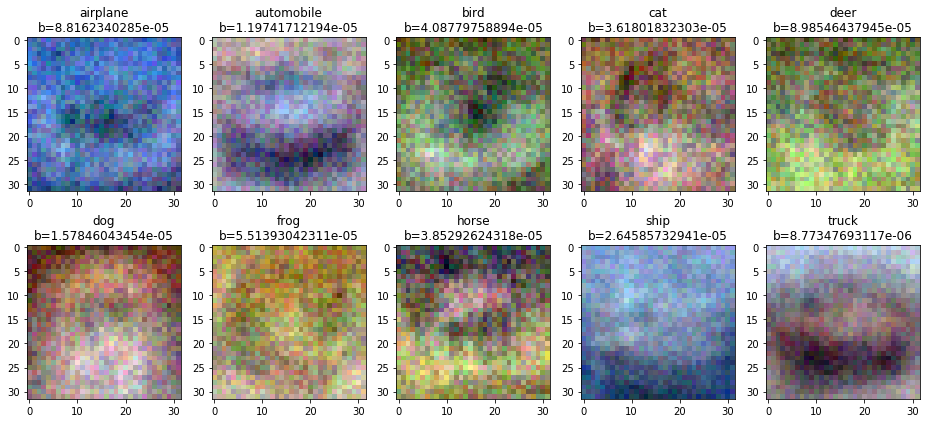

In [37]:
plot_CIFAR_linear_classes(W)

In [38]:
# Assume X_test is [3073 x 10000], Y_test [10000 x 1]
scores = W.dot(X_test.T) # 10 x 10000, the class scores for all test examples
# find the index with max score in each column (the predicted class)
Yte_predict = np.argmax(scores, axis = 0)
# and calculate accuracy (fraction of predictions that are correct)
np.mean(Yte_predict == Yte)
# returns 0.1555

0.1018

nolearn.lasagne implementation of previous model

In [39]:
import theano
import lasagne
from lasagne import layers
from lasagne.updates import sgd
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator
from nolearn.lasagne import TrainSplit

Using cuDNN version 6021 on context None
Mapped name None to device cuda0: GeForce GTX 1060 6GB (0000:01:00.0)


In [40]:
net1 = NeuralNet(
    layers=[('input', layers.InputLayer),
            ('output', layers.DenseLayer),
            ],
    # input layer(batch size, input dimensions)
    input_shape=(128,3072),
    # output
    output_nonlinearity=lasagne.nonlinearities.linear,
    output_W=lasagne.init.Uniform(range=(0,0.0001)),
    output_b=lasagne.init.Uniform(range=(0,0.0001)), 
    output_num_units=10,
    # optimization method params
    batch_iterator_test=BatchIterator(batch_size=128,shuffle=True),
    batch_iterator_train=BatchIterator(batch_size=128,shuffle=True),
    train_split=TrainSplit(eval_size=0.0),
    objective_loss_function = lasagne.objectives.multiclass_hinge_loss,
    objective_l2 = 0.001,
    update=sgd,
    update_learning_rate=0.000001,
    max_epochs=10,
    verbose=1,
    )

In [41]:
nn = net1.fit(Xtr_rows,Ytr)

# Neural Network with 30730 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input     3072
  1  output      10

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  -----
      1    10.12938         nan        nan          nan  1.27s
      2     7.63206         nan        nan          nan  1.23s
      3     7.68332         nan        nan          nan  1.21s
      4     7.00727         nan        nan          nan  1.24s
      5     7.06519         nan        nan          nan  1.21s
      6     7.14182         nan        nan          nan  1.25s
      7     6.89415         nan        nan          nan  1.22s
      8     6.80550         nan        nan          nan  1.22s
      9     6.78950         nan        nan          nan  1.22s
     10     6.66649         nan        nan          nan  1.22s


In [42]:
input_var = net1.layers_['input'].input_var
output_layer = layers.get_output(net1.layers_['output'], deterministic=True)
f_output = theano.function([input_var], output_layer)

In [43]:
def get_W_b_from_GPU(nnet,layer):
    # Get theano GPU tensor reference from layer
    gpuW = nnet.layers_[layer].W
    gpub = nnet.layers_[layer].b
    # Get data from GPU tensor to CPU tensor
    cpuW = theano.gpuarray.basic_ops.host_from_gpu(gpuW)
    cpub = theano.gpuarray.basic_ops.host_from_gpu(gpub)
    # Evaluate CPU tensor to get numpy array
    npyW = cpuW.eval()
    npyb = cpub.eval()
    return npyW, npyb

In [44]:
gW, gb = get_W_b_from_GPU(net1,'output')

In [45]:
gWb = np.concatenate((gW.T,gb.reshape(gb.shape[0],1)),axis=1)

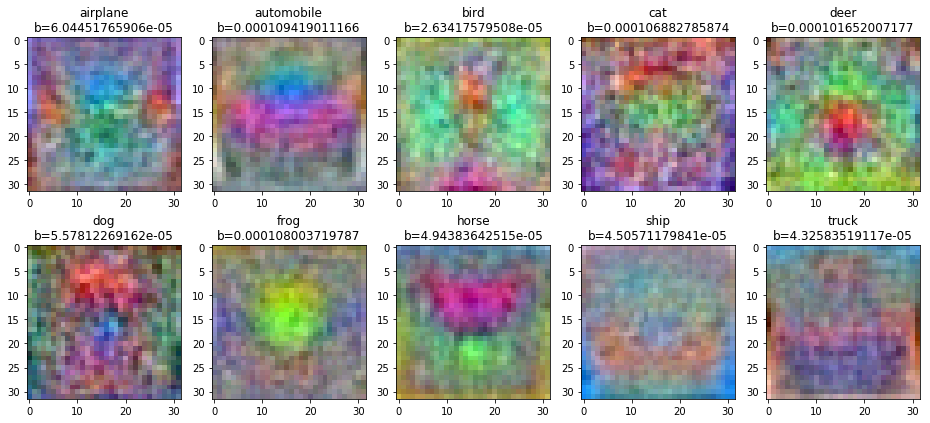

In [46]:
plot_CIFAR_linear_classes(gWb)

In [47]:
# Benchmark lasagne speed
%timeit -n 20 f_output(Xte_rows)

20 loops, best of 3: 193 ms per loop


In [48]:
# Reference numpy speed
%timeit -n 20 Xte_rows.dot(gW)+gb

20 loops, best of 3: 207 ms per loop


In [49]:
# Reference numpy speed with 1-padded test data
# Lasagne not using Wx+b => [W,b][x,1]?
%timeit -n 20 X_test.dot(gWb.T)

20 loops, best of 3: 90 ms per loop


In [50]:
# Using nolearn's predict_proba method
%timeit -n 20 net1.predict_proba(Xte_rows)

20 loops, best of 3: 174 ms per loop


In [51]:
def compare(a,b):
    return np.mean(np.abs(a-b)/np.maximum(a,b))

In [52]:
print(np.allclose(f_output(Xte_rows),Xte_rows.dot(gW)+gb))
print(np.allclose(X_test.dot(gWb.T),Xte_rows.dot(gW)+gb))
print(np.allclose(X_test.dot(gWb.T),f_output(Xte_rows)))
print(np.allclose(net1.predict_proba(Xte_rows),f_output(Xte_rows)))

True
False
False
True


In [53]:
# scores = Xte_rows.dot(gW)+gb # f_output(X_test)
Yte_predict = net1.predict(Xte_rows) # np.argmax(scores, axis = 1)
np.mean(Yte_predict == Yte)

0.099900000000000003

#4 Backpropagation, Intuitions

In [54]:
import math

In [55]:
w = [2,-3,-3] # assume some random weights and data
x = [-1, -2]

# forward pass
dot = w[0]*x[0] + w[1]*x[1] + w[2]
f = 1.0 / (1 + math.exp(-dot)) # sigmoid function

# backward pass through the neuron (backpropagation)
ddot = (1 - f) * f # gradient on dot variable, using the sigmoid gradient derivation
dx = [w[0] * ddot, w[1] * ddot] # backprop into x
dw = [x[0] * ddot, x[1] * ddot, 1.0 * ddot] # backprop into w
# we're done! we have the gradients on the inputs to the circuit

print(f)
print(dw)
print(dx)

0.7310585786300049
[-0.19661193324148185, -0.3932238664829637, 0.19661193324148185]
[0.3932238664829637, -0.5898357997244456]
